# Modeling E-Commerce data using Python and Postgres

I will show how to build a data model using Python and stored it in a PostgreSQL database, as our Data Warehouse.

## 1. Downloading the data

I download the data from Kaggle (https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/)

## 2. Reading the data

In [ ]:
# Import libraries

import pandas as pd

In [ ]:
# Read the data

customers = pd.read_csv("dataset/customers.csv")
order_items = pd.read_csv("dataset/order_items.csv")
order_payments = pd.read_csv("dataset/order_payments.csv")
orders = pd.read_csv("dataset/orders.csv")
products = pd.read_csv("dataset/products.csv")
sellers = pd.read_csv("dataset/sellers.csv")

## 3. Presenting the schema of our tables

Here is the schema of our tables, and the relationship between our tables :

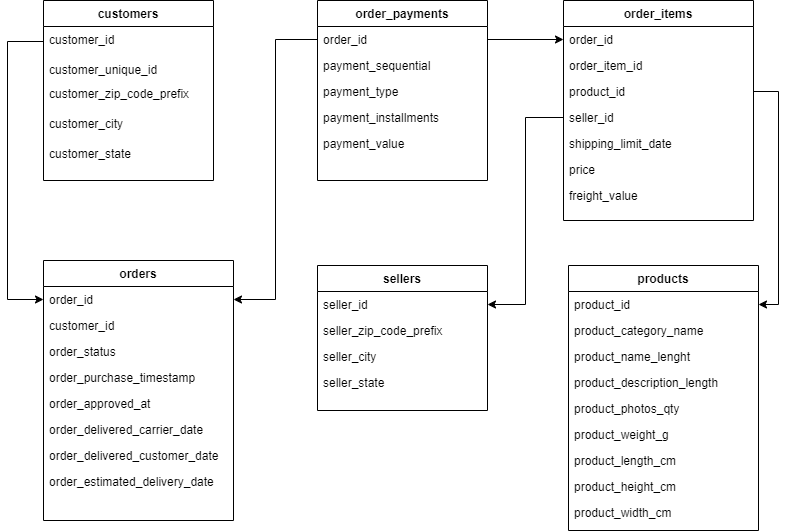

In [ ]:
customers.head()

In [ ]:
customers.info()

In [ ]:
orders.info()

In [ ]:
order_payments.info()

In [ ]:
orders.info()

In [ ]:
order_items.info()

In [ ]:
sellers.info()

In [ ]:
products.info()

## 4. Defining the use case of the data

To know what data to put into the tables of our data model, we need to know what the data is going to be used for. This part is usually done by having a conversation with the users of the data (analysts, managers, scientists, etc). Once we know what will be the most relevant data for our business use case, then we can create a data model for that required data.

Let’s create a data model that supports the following analysis:
- What places contributed the most/least to product sales?
- Which seller sold the most/least products?
- Best and worst performing products.
- Date for everything.

## 5. Creating a star schema

Here is our data model with tables to be loaded in our Data Warehouse:

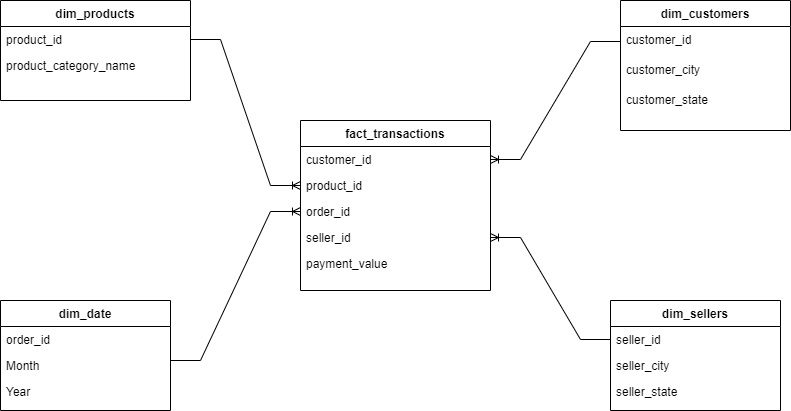

## 6. Creating the data model tables from the existing tables

### 6.1 Creating the fact_transactions table

Let’s start with the fact table. From the default schema we can see that the columns that we need are distributed among different tables, so first we need to join those tables. In two steps, we will join **orders**, **order_payments** and **order_items** tables on *order_id* key to produce a unique table.

In [ ]:
temp1_orders = pd.merge(orders, order_payments, on='order_id')
temp2_orders = pd.merge(temp1, order_items, on='order_id')

**temp2_orders** table contain all the columns that we require in the **fact_transactions** table of the model.

In [ ]:
temp2_orders.info()

In [ ]:
# Creating the fact_transactions table

fact_transactions = temp2_orders[['customer_id', 'product_id', 'order_id', 'seller_id', 'payment_value']]
fact_transactions.head()

### 6.2 Creating the dim_customers table

In [ ]:
# Creating the dim_customers table

dim_customers = customers[['customer_id', 'customer_city', 'customer_state']]
dim_customers.head()

### 6.2 Creating the dim_products table

In [ ]:
# Creating the dim_products table

dim_products = products[['product_id', 'product_category_name']]
dim_products.head()

### 6.4 Creating the dim_sellers table

In [ ]:
# Creating the dim_sellers table

dim_sellers = sellers[['seller_id', 'seller_city', 'seller_state']]
dim_sellers.head()

### 6.5 Creating the dim_date table

First, we have to extract the *order_id* and the *order_purchase_timestamp* columns from the **orders** table.

In [ ]:
# Extracting order_id and order_purchase_timestamp columns from the orders table

dim_date = orders[['order_id', 'order_purchase_timestamp']]
dim_date.head()

Second, We have to convert *order_purchase_timestamp* column into the datetime format

In [ ]:
# Converting order_purchase_timestamp column into datetime format
dim_date['order_purchase_timestamp'] = pd.to_datetime(dim_date['order_purchase_timestamp'])

Last, We can now extract the month and year from the *order_purchase_timestamp* datetime column.

In [ ]:
dim_date['Month'] = dim_date['order_purchase_timestamp'].dt.month
dim_date['Year'] = dim_date['order_purchase_timestamp'].dt.year
dim_date.head()

Let now keep only the *order_id*, *Month* and *Year* Columns in the **dim_date** table

In [ ]:
dim_date = dim_date[['order_id', 'Month', 'Year']]
dim_date.head()

## 7. Creating a PostgreSQL Database and connecting to it

Now, to connect to our PostgreSQL database from Python, we are going to use the psycopg2 library.

Note that If you don’t have this library installed in your system, you first need to install it using:

In [ ]:
#!pip install psycopg2

In [ ]:
# Import psycopg2
import psycopg2

We will use the following code to create our database:

In [ ]:
try:
    # Connecting to the default postgres database
    conn = psycopg2.connect("host = localhost dbname = postgres user = test password = test") 
except psycopg2.Error as e :
    print("Error, couldnt connect to database")   
    print(e)

In [ ]:
# Any changes we make from here will be updated automatically in the database
conn.set_session(autocommit = True) 
curr = conn.cursor()

In [ ]:
# Creating our database
curr.execute("Create Database ecommerce")

In [ ]:
# Closing connection to the default database
conn.close()   

We can see our database in the PostgreSQL server using pgAdmin interface:

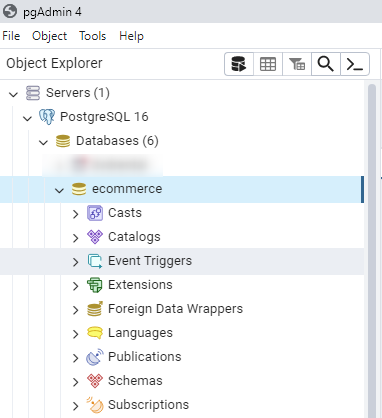

Now let connect to our newly created ***ecommerce*** database:

In [ ]:
try:
    # Connecting to our ecommerce database
    conn = psycopg2.connect("host = localhost dbname = ecommerce user = test password = test") # connecting to our new database
except psycopg2.Error as e :
    print("error, couldnt connect to database")
    print(e)

In [ ]:
 # Creating a cursor to be able to communicate to our database
conn.set_session(autocommit = True)
curr = conn.cursor()

## 8. Creating our model tables in the database

We need to write SQL queries to create our table and execute it using curr.execute().

In [ ]:
# Storing our SQL query inside a variable, and then create a table 
fact_create = ("""Create table if not exists fact_transactions(
customer_id varchar,
product_id varchar,
order_id varchar, 
seller_id varchar,
payment_value float)""") 
curr.execute(fact_create)

We can now verify in the PostgreSQL database that the **fact_transactions** table has been created:

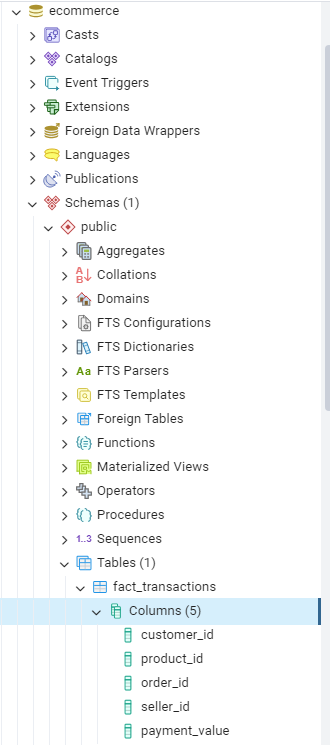

We will do the same for the dim tables.

In [ ]:
# Storing our SQL query inside a variable, and then create a table 
dim_customers_create_db_table = ("""Create table if not exists dim_customers(
customer_id varchar,
customer_city varchar,
customer_state varchar)""") 
curr.execute(dim_customers_create_db_table)

In [ ]:
# Storing our SQL query inside a variable, and then create a table 
dim_products_create_db_table = ("""Create table if not exists dim_products(
product_id varchar,
product_category_name varchar)""") 
curr.execute(dim_products_create_db_table)

In [ ]:
# Storing our SQL query inside a variable, and then create a table 
dim_sellers_create_db_table = ("""Create table if not exists dim_sellers(
seller_id varchar,
seller_city varchar,
seller_state varchar)""") 
curr.execute(dim_sellers_create_db_table)

In [ ]:
# Storing our SQL query inside a variable, and then create a table 
dim_date_create_db_table = ("""Create table if not exists dim_date(
order_id varchar,
Month integer,
Year integer)""") 
curr.execute(dim_date_create_db_table)

Once done, we will have all our tables inside the ***ecommerce*** database:

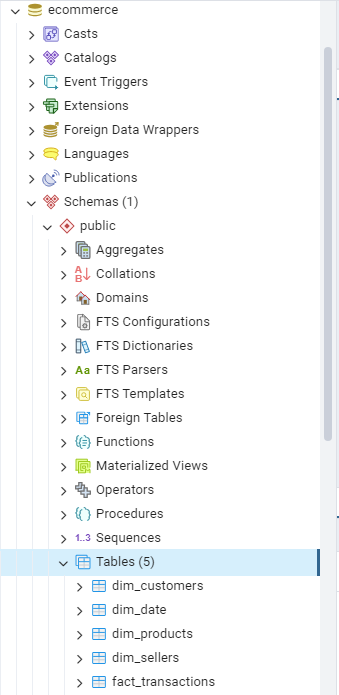

## 9. Inserting data into database tables

We write a SQL query to insert rows into the tables. We read each row from the dataframe and insert it into the corresponding table in the ***ecommerce*** database.

In [ ]:
# Insert rows into the fact_transactions table

# Storing a SQL query to insert data into a table inside a variable
fact_insert_db_table = ("""insert into fact_transactions(
customer_id,
product_id,
order_id , 
seller_id ,
payment_value)
values (%s, %s, %s, %s, %s)""")

# iterrows returns index and information stored in a row of a data frame
for i, row in fact_transactions.iterrows():
    # So we are reading each row from fact_transactions dataframe and inserting it into fact_transactions table in the database 
    curr.execute(fact_insert_db_table, list(row))

In [ ]:
# Insert rows into the dim_customers table

# Storing a SQL query to insert data into a table inside a variable
dim_customers_insert_db_table = ("""insert into dim_customers(
customer_id,
customer_city,
customer_state)
values (%s, %s, %s)""")

# iterrows returns index and information stored in a row of a data frame
for i, row in dim_customers.iterrows():
    # So we are reading each row from fact_transactions dataframe and inserting it into fact_transactions table in the database 
    curr.execute(dim_customers_insert_db_table, list(row))

In [ ]:
# Insert rows into the dim_products table

# Storing a SQL query to insert data into a table inside a variable
dim_products_insert_db_table = ("""insert into dim_products(
product_id,
product_category_name)
values (%s, %s)""")

# iterrows returns index and information stored in a row of a data frame
for i, row in dim_products.iterrows():
    # So we are reading each row from fact_transactions dataframe and inserting it into fact_transactions table in the database 
    curr.execute(dim_products_insert_db_table, list(row))

In [ ]:
# Insert rows into the dim_sellers table

# Storing a SQL query to insert data into a table inside a variable
dim_sellers_insert_db_table = ("""insert into dim_sellers(
seller_id,
seller_city,
seller_state)
values (%s, %s, %s)""")

# iterrows returns index and information stored in a row of a data frame
for i, row in dim_sellers.iterrows():
    # So we are reading each row from fact_transactions dataframe and inserting it into fact_transactions table in the database 
    curr.execute(dim_sellers_insert_db_table, list(row))

In [ ]:
# Insert rows into the dim_date table

# Storing a SQL query to insert data into a table inside a variable
dim_date_insert_db_table = ("""insert into dim_date(
order_id,
Month,
Year)
values (%s, %s, %s)""")

# iterrows returns index and information stored in a row of a data frame
for i, row in dim_date.iterrows():
    # So we are reading each row from fact_transactions dataframe and inserting it into fact_transactions table in the database 
    curr.execute(dim_date_insert_db_table, list(row))